<a href="https://colab.research.google.com/github/Jiae-yang/2020NLP_project/blob/main/xgboost_hyper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive/')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Importing Required Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#SMOTE to balance the Imbalance Data
from imblearn.over_sampling import SMOTE

#for Spliting Data and Hyperparameter Tuning 
from sklearn.model_selection import train_test_split, GridSearchCV

#Importing Machine Learning Model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
    
#Bagging Algo
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

from sklearn.neural_network import MLPClassifier

#To tranform data
from sklearn import preprocessing

#statistical Tools
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc

#Setting Format
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = None

import warnings
warnings.filterwarnings("ignore")

In [6]:
#train = pd.read_csv("../input/lt-vehicle-loan-default-prediction/train.csv")
#test = pd.read_csv("../input/lt-vehicle-loan-default-prediction/test.csv")
train = pd.read_csv("/content/drive/MyDrive/train.csv")
test = pd.read_csv("/content/drive/MyDrive/test.csv")

In [7]:
test.shape,train.shape

((112392, 40), (233154, 41))

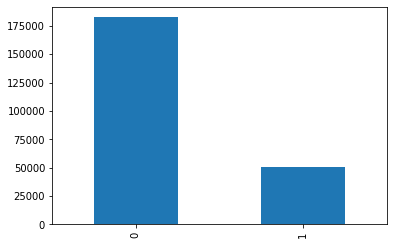

In [8]:
train.loan_default.value_counts().plot(kind='bar')

In [9]:
#Replacing all the Spaces with '_'
train.columns = train.columns.str.replace('.','_')

In [10]:
train.isna().sum()

#So only Employment Type data is missing

UniqueID                                  0
disbursed_amount                          0
asset_cost                                0
ltv                                       0
branch_id                                 0
supplier_id                               0
manufacturer_id                           0
Current_pincode_ID                        0
Date_of_Birth                             0
Employment_Type                        7661
DisbursalDate                             0
State_ID                                  0
Employee_code_ID                          0
MobileNo_Avl_Flag                         0
Aadhar_flag                               0
PAN_flag                                  0
VoterID_flag                              0
Driving_flag                              0
Passport_flag                             0
PERFORM_CNS_SCORE                         0
PERFORM_CNS_SCORE_DESCRIPTION             0
PRI_NO_OF_ACCTS                           0
PRI_ACTIVE_ACCTS                

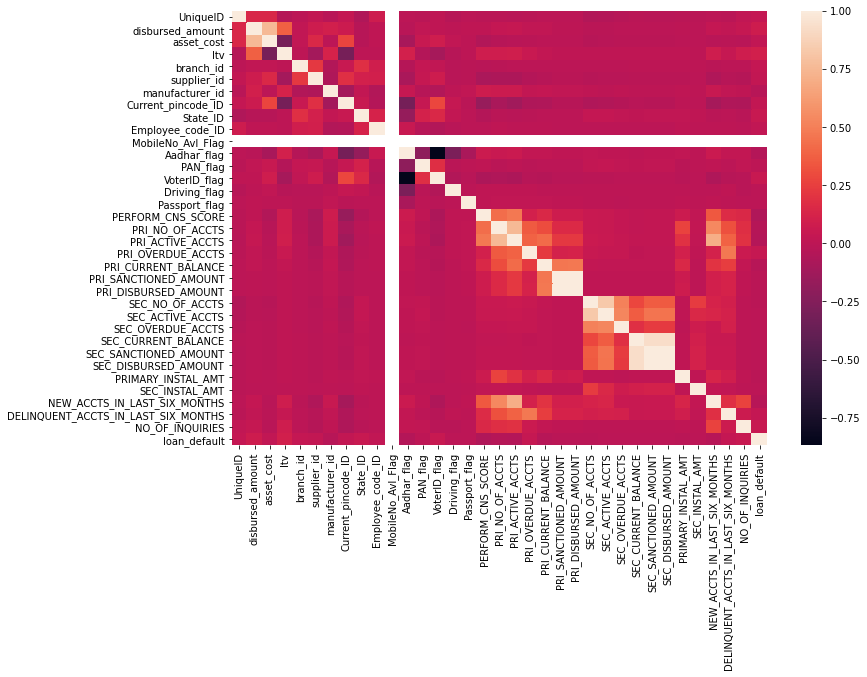

In [11]:
#Data Correlation
plt.figure(figsize=(12,8))
sns.heatmap(train.corr())

In [12]:
#Lets Look at few columns

columns_unique = ['UniqueID','MobileNo_Avl_Flag',
         'Current_pincode_ID','Employee_code_ID',
         'NO_OF_INQUIRIES','State_ID',
         'branch_id','manufacturer_id','supplier_id']


unique_col = train[columns_unique]

In [13]:
unique_col.head()

,UniqueID,MobileNo_Avl_Flag,Current_pincode_ID,Employee_code_ID,NO_OF_INQUIRIES,State_ID,branch_id,manufacturer_id,supplier_id
0,420825,1,1441,1998,0,6,67,45,22807
1,537409,1,1502,1998,0,6,67,45,22807
2,417566,1,1497,1998,0,6,67,45,22807
3,624493,1,1501,1998,1,6,67,45,22807
4,539055,1,1495,1998,1,6,67,45,22807


In [14]:
#Looking at all unique values
for i in unique_col.columns:
    print(i," : distinct_value")
    print(unique_col[i].nunique()," : No. of unique Items")
    #print(unique_col[i].unique())
    print("-"*30)
    print("")

UniqueID  : distinct_value
233154  : No. of unique Items
------------------------------

MobileNo_Avl_Flag  : distinct_value
1  : No. of unique Items
------------------------------

Current_pincode_ID  : distinct_value
6698  : No. of unique Items
------------------------------

Employee_code_ID  : distinct_value
3270  : No. of unique Items
------------------------------

NO_OF_INQUIRIES  : distinct_value
25  : No. of unique Items
------------------------------

State_ID  : distinct_value
22  : No. of unique Items
------------------------------

branch_id  : distinct_value
82  : No. of unique Items
------------------------------

manufacturer_id  : distinct_value
11  : No. of unique Items
------------------------------

supplier_id  : distinct_value
2953  : No. of unique Items
------------------------------



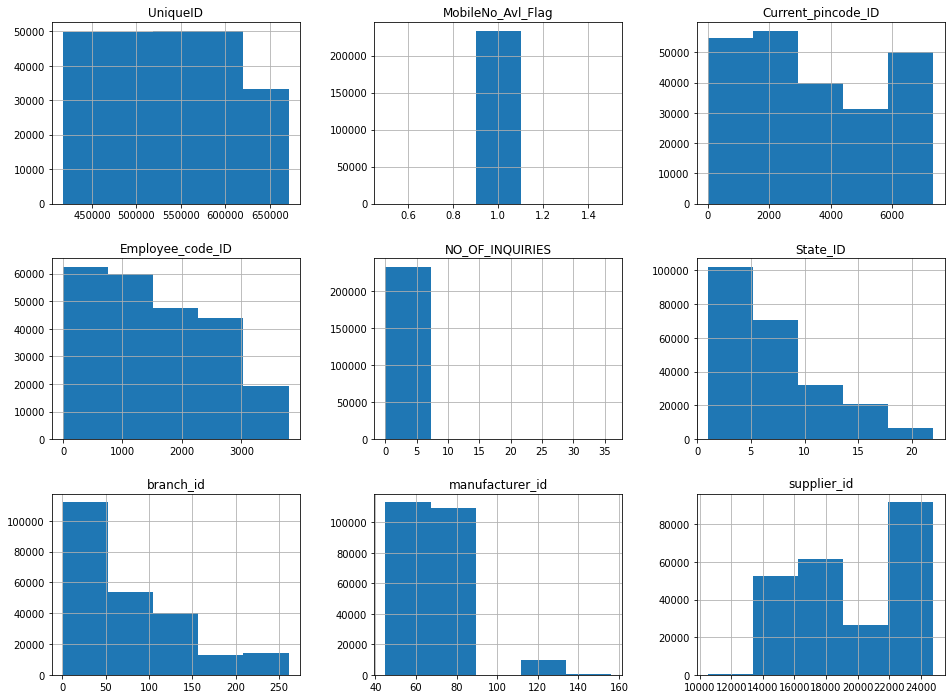

In [15]:
unique_col.hist(bins=5, figsize=(16,12))
plt.show()

In [16]:
def columns_drop(data):
    data.drop(unique_col,axis=1,inplace=True)

In [17]:
columns_drop(train)

In [18]:
#Now we have 2 Columns named "AVERAGE_ACCT_AGE" & "CREDIT_HISTORY_LENGTH".
#They have AplhNumeric Values Lets change them to Months

def change_col_month(col):
    year = int(col.split()[0].replace('yrs',''))
    month = int(col.split()[1].replace('mon',''))
    return year*12+month

def months_transformation(data):
    data['CREDIT_HISTORY_LENGTH'] = data['CREDIT_HISTORY_LENGTH'].apply(change_col_month)
    data['AVERAGE_ACCT_AGE'] = data['AVERAGE_ACCT_AGE'].apply(change_col_month)

In [19]:
months_transformation(train)

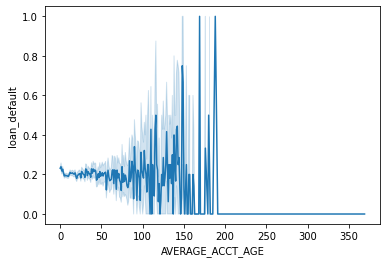

In [20]:
#plot = data.iloc[:test.shape[0]]
plot = train[train['AVERAGE_ACCT_AGE']<175]
sns.lineplot(x=train['AVERAGE_ACCT_AGE'],y=train['loan_default'])

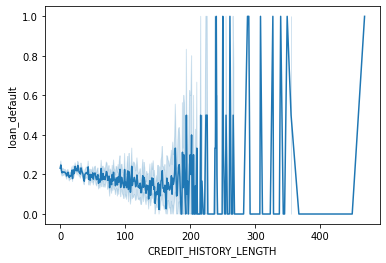

In [21]:
#plot = data.iloc[:test.shape[0]]
plot = train[train['CREDIT_HISTORY_LENGTH']<200]
sns.lineplot(x=train['CREDIT_HISTORY_LENGTH'],y=train['loan_default'])

In [22]:
train.PERFORM_CNS_SCORE_DESCRIPTION.value_counts()

No Bureau History Available                                116950
C-Very Low Risk                                             16045
A-Very Low Risk                                             14124
D-Very Low Risk                                             11358
B-Very Low Risk                                              9201
M-Very High Risk                                             8776
F-Low Risk                                                   8485
K-High Risk                                                  8277
H-Medium Risk                                                6855
E-Low Risk                                                   5821
I-Medium Risk                                                5557
G-Low Risk                                                   3988
Not Scored: Sufficient History Not Available                 3765
J-High Risk                                                  3748
Not Scored: Not Enough Info available on the customer        3672
Not Scored

In [23]:
def replace_not_scored(n):
    #here we are spliting letters before '-'.
    score=n.split("-")
    
    if len(score)!=1:
        return score[0]
    else:
        return 'N'

def transform_CNS_Description(data):
    data['CNS_SCORE_DESCRIPTION']=data['PERFORM_CNS_SCORE_DESCRIPTION'].apply(replace_not_scored).astype(np.object)
    
    #Now Transform CNS Score Description data into Numbers

    sub_risk = {'N':-1, 'K':0, 'J':1, 'I':2, 'H':3, 'G':4, 'E':5,'F':6, 'L':7, 'M':8, 'B':9, 'D':10, 'A':11, 'C':12}

    data['CNS_SCORE_DESCRIPTION'] = data['CNS_SCORE_DESCRIPTION'].apply(lambda x: sub_risk[x])
    
transform_CNS_Description(train)

In [24]:
def transform_PERFORM_CNS_SCORE_DESCRIPTION(data):
    #Replacing all the values into Common Group

    data['PERFORM_CNS_SCORE_DESCRIPTION'].replace({'C-Very Low Risk':'Very Low Risk',
                                                 'A-Very Low Risk':'Very Low Risk',
                                                 'D-Very Low Risk':'Very Low Risk',
                                                 'B-Very Low Risk':'Very Low Risk',
                                                 'M-Very High Risk':'Very High Risk',
                                                 'L-Very High Risk':'Very High Risk',
                                                 'F-Low Risk':'Low Risk',
                                                 'E-Low Risk':'Low Risk',
                                                 'G-Low Risk':'Low Risk',
                                                 'H-Medium Risk':'Medium Risk',
                                                 'I-Medium Risk':'Medium Risk',
                                                 'J-High Risk':'High Risk',
                                                 'K-High Risk':'High Risk'},
                                                  inplace=True)

    #Transformin them into Numeric Features

    risk_map = {'No Bureau History Available':-1, 
                  'Not Scored: No Activity seen on the customer (Inactive)':-1,
                  'Not Scored: Sufficient History Not Available':-1,
                  'Not Scored: No Updates available in last 36 months':-1,
                  'Not Scored: Only a Guarantor':-1,
                  'Not Scored: More than 50 active Accounts found':-1,
                  'Not Scored: Not Enough Info available on the customer':-1,
                  'Very Low Risk':4,
                  'Low Risk':3,
                  'Medium Risk':2, 
                  'High Risk':1,
                  'Very High Risk':0}

    data['PERFORM_CNS_SCORE_DESCRIPTION'] = data['PERFORM_CNS_SCORE_DESCRIPTION'].map(risk_map)

transform_PERFORM_CNS_SCORE_DESCRIPTION(train)

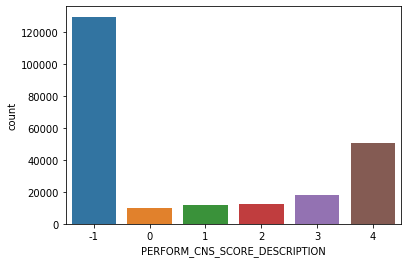

In [25]:
sns.countplot(x = train['PERFORM_CNS_SCORE_DESCRIPTION'])

In [26]:
train.Employment_Type.value_counts()

Self employed    127635
Salaried          97858
Name: Employment_Type, dtype: int64

In [27]:
defa = pd.crosstab(train['Employment_Type'], train['loan_default'])
print(defa)

loan_default         0      1
Employment_Type              
Salaried         77948  19910
Self employed    98578  29057


In [28]:
def fill_employment_type(data):
    data['Employment_Type'] = data['Employment_Type'].fillna('Salaried')
    employment_map = {'Self employed':0, 'Salaried':1, 'Not_employed':-1}

    data['Employment_Type'] = data['Employment_Type'].apply(lambda x: employment_map[x])
fill_employment_type(train)

In [29]:
import scipy.stats as stats
chi_sq, p_value, deg_freedom, exp_freq = stats.chi2_contingency(defa)
print('Chi Square Statistics',chi_sq)
print('p-value',p_value)
print('Degree of freedom',deg_freedom)

Chi Square Statistics 190.6579236758318
p-value 2.2841351170641894e-43
Degree of freedom 1


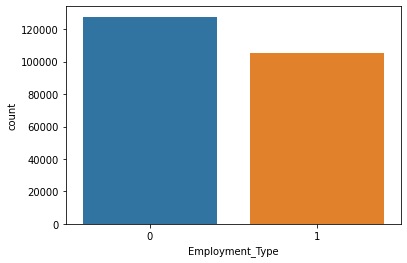

In [30]:
sns.countplot(x = train['Employment_Type'])

In [31]:
pri_columns = ['PRI_NO_OF_ACCTS','SEC_NO_OF_ACCTS',
           'PRI_ACTIVE_ACCTS','SEC_ACTIVE_ACCTS',
           'PRI_OVERDUE_ACCTS','SEC_OVERDUE_ACCTS',
           'PRI_CURRENT_BALANCE','SEC_CURRENT_BALANCE',
           'PRI_SANCTIONED_AMOUNT','SEC_SANCTIONED_AMOUNT',
           'PRI_DISBURSED_AMOUNT','SEC_DISBURSED_AMOUNT',
           'PRIMARY_INSTAL_AMT', 'SEC_INSTAL_AMT']

pri_df = train[pri_columns]

In [32]:
def new_col(data):
    #Creating and Sorting Columns

    data['NO_OF_ACCTS'] = data['PRI_NO_OF_ACCTS'] + data['SEC_NO_OF_ACCTS']

    data['ACTIVE_ACCTS'] = data['PRI_ACTIVE_ACCTS'] + data['SEC_ACTIVE_ACCTS']

    data['OVERDUE_ACCTS'] = data['PRI_OVERDUE_ACCTS'] + data['SEC_OVERDUE_ACCTS']

    data['CURRENT_BALANCE'] = data['PRI_CURRENT_BALANCE'] + data['SEC_CURRENT_BALANCE']

    data['SANCTIONED_AMOUNT'] = data['PRI_SANCTIONED_AMOUNT'] + data['SEC_SANCTIONED_AMOUNT']

    data['DISBURSED_AMOUNT'] = data['PRI_DISBURSED_AMOUNT'] + data['SEC_DISBURSED_AMOUNT']

    data['INSTAL_AMT'] = data['PRIMARY_INSTAL_AMT'] + data['SEC_SANCTIONED_AMOUNT']
    
    data.drop(pri_columns, axis=1, inplace=True)

new_col(train)

In [33]:
new_columns = ['NO_OF_ACCTS', 'ACTIVE_ACCTS', 'OVERDUE_ACCTS', 'CURRENT_BALANCE',
       'SANCTIONED_AMOUNT', 'DISBURSED_AMOUNT', 'INSTAL_AMT']

for i in new_columns:
    print(i," : distinct_value")
    print(train[i].nunique()," : No. of unique Items")
    #print(data[i].unique())
    print("-"*30)
    print("")

NO_OF_ACCTS  : distinct_value
108  : No. of unique Items
------------------------------

ACTIVE_ACCTS  : distinct_value
41  : No. of unique Items
------------------------------

OVERDUE_ACCTS  : distinct_value
22  : No. of unique Items
------------------------------

CURRENT_BALANCE  : distinct_value
72483  : No. of unique Items
------------------------------

SANCTIONED_AMOUNT  : distinct_value
45367  : No. of unique Items
------------------------------

DISBURSED_AMOUNT  : distinct_value
48958  : No. of unique Items
------------------------------

INSTAL_AMT  : distinct_value
30049  : No. of unique Items
------------------------------



In [34]:
train.Date_of_Birth.min(), train.Date_of_Birth.max()

('01-01-00', '31-12-99')

In [35]:
df_age = train[['disbursed_amount', 'asset_cost', 'ltv', 'Date_of_Birth','DisbursalDate','loan_default']]
df_age.tail()

,disbursed_amount,asset_cost,ltv,Date_of_Birth,DisbursalDate,loan_default
233149,63213,105405,60.72000,01-08-88,26-10-18,0
233150,73651,100600,74.95000,05-12-88,23-10-18,0
233151,33484,71212,48.45000,01-06-76,24-10-18,0
233152,34259,73286,49.10000,26-03-94,29-09-18,0
233153,75751,116009,66.81000,18-02-84,27-10-18,0


In [36]:
def age(dob):
    yr = int(dob[-2:])
    if yr >=0 and yr < 20:
        return yr + 2000
    else:
         return yr + 1900
        
df_age['Date_of_Birth'] = df_age['Date_of_Birth'].apply(age)
df_age['DisbursalDate'] = df_age['DisbursalDate'].apply(age)
df_age['Age']=df_age['DisbursalDate']-df_age['Date_of_Birth']
df_age=df_age.drop(['DisbursalDate','Date_of_Birth'],axis=1)

df_age.head()

,disbursed_amount,asset_cost,ltv,loan_default,Age
0,50578,58400,89.55000,0,34
1,47145,65550,73.23000,1,33
2,53278,61360,89.63000,0,33
3,57513,66113,88.48000,1,25
4,52378,60300,88.39000,1,41


In [37]:
def calculate_age(data):
    data['Date_of_Birth'] = data['Date_of_Birth'].apply(age)
    data['DisbursalDate'] = data['DisbursalDate'].apply(age)
    # Age of applicant when he/she applied for Loan
    data['Age'] = data['DisbursalDate'] - data['Date_of_Birth']
    data = data.drop( ['DisbursalDate', 'Date_of_Birth'], axis=1)
    
calculate_age(train)

In [38]:
transformed = []
transformed_with_one = []
not_transformed = []

def column_to_transform(data):

    num_col = ['disbursed_amount', 'asset_cost', 'ltv', 'PERFORM_CNS_SCORE',
            'NEW_ACCTS_IN_LAST_SIX_MONTHS', 'CREDIT_HISTORY_LENGTH',
           'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS', 'AVERAGE_ACCT_AGE',
           'NO_OF_ACCTS', 'ACTIVE_ACCTS', 'OVERDUE_ACCTS', 'CURRENT_BALANCE',
           'SANCTIONED_AMOUNT', 'DISBURSED_AMOUNT', 'INSTAL_AMT', 'Age']
    
    num_col_data = data[num_col]
    
    def transformation_boxcox(num_col_data):
    
        from scipy.stats import boxcox

        for i in num_col:
            if num_col_data[i].min() > 0:
                num_col_data[i] = boxcox(num_col_data[i])[0]
                transformed.append(i)
            elif num_col_data[i].min() == 0:
                num_col_data[i] = boxcox(num_col_data[i]+1)[0]
                transformed_with_one.append(i)
            else:
                num_col_data[i] = num_col_data[i]
                not_transformed.append(i)
        print("Successful")
    
    transformation_boxcox(data)

column_to_transform(train)

Successful


In [39]:
def data_processing(data):
    test.columns = test.columns.str.replace('.','_')
    columns_drop(data)
    months_transformation(data)
    transform_CNS_Description(data)
    transform_PERFORM_CNS_SCORE_DESCRIPTION(data)
    fill_employment_type(data)
    new_col(data)
    mode_impute_outlier(data)
    calculate_age(data)
    column_to_transform(data)
    preprocessing.RobustScaler()
    scaler.transform(data)
    return data.shape

In [40]:
X = train.drop(['loan_default'], axis=1)
y = train['loan_default']

In [41]:
smote = SMOTE()
X_tf,y_tf = smote.fit_resample(X,y)
X_tf.shape, y_tf.shape

((365086, 26), (365086,))

In [42]:
scaler = preprocessing.RobustScaler()
X_tf = scaler.fit_transform(X_tf)

# Split the data into training and testing sets 
x_train,x_test,y_train,y_test = train_test_split(X_tf,y_tf,test_size = .1, random_state = 3300)

print(x_train.shape[0], x_test.shape[0])

328577 36509


In [43]:
accuracy = {}
roc_r = {}

def train_model(model, model_name):
    print(model_name)
    
    # Fitting model
    model = model.fit(x_train, y_train)
    pred = model.predict(x_test)
    
    #Model accuracy
    acc = accuracy_score(y_test, pred)*100
    accuracy[model_name] = acc
    print('accuracy_score',acc)
    print('precision_score',precision_score(y_test, pred)*100)
    print('recall_score',recall_score(y_test, pred)*100)
    print('f1_score',f1_score(y_test, pred)*100)
    
    
    #ROC Score
    roc_score = roc_auc_score(y_test, pred)*100
    roc_r[model_name] = roc_score
    print('roc_auc_score',roc_score)
    
    # Confusion matrix
    print('confusion_matrix')
    print(pd.DataFrame(confusion_matrix(y_test, pred)))
    
    #ROC Score
    fpr, tpr, threshold = roc_curve(y_test, pred)
    roc_auc = auc(fpr, tpr)*100
    
    #ROC Plot
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [47]:
# hyper parameter 튜닝3 
# n_estimators = 1500, nthread  = 4, max_depth = 15, min_child_weight = 5, learning_rate=0.1
from sklearn.model_selection import GridSearchCV
max_depth = [i for i in range(10,21,5)]
# min_samples_leaf = [i for i in range(500,2500,1000)]
# max_features = [20,25,30]
n_estimators = [i for i in range(500,1600,500)]
learning_rate = [0.05, 0.1]
param_grid = dict(max_depth=max_depth,n_estimators=n_estimators,learning_rate=learning_rate  )
param_grid

{'learning_rate': [0.05, 0.1],
 'max_depth': [10, 15, 20],
 'n_estimators': [500, 1000, 1500]}

In [48]:
from sklearn.ensemble import GradientBoostingClassifier
clf = XGBClassifier(random_state=100)
# grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring="accuracy")
grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring="roc_auc")
# xgb_grid = GridSearchCV(xgb, param_grid = xgb_param_grid, scoring="roc_auc", n_jobs= -1, verbose = 1)

In [ ]:
grid_result = grid.fit(X_tf, y_tf)
print("Best Score: ",grid_result.best_score_)
print("Best Score: ",grid_result.best_params_)

In [ ]:
result = pd.DataFrame(grid.cv_results_)
result.sort_values(by=['rank_test_score'], inplace=True)

In [ ]:
result[['params', 'mean_test_score', 'rank_test_score']].head(10)